<font color="white">.</font> | <font color="white">.</font> | <font color="white">.</font>
-- | -- | --
![NASA](http://www.nasa.gov/sites/all/themes/custom/nasatwo/images/nasa-logo.svg) | <h1><font size="+3">ASTG Python Courses</font></h1> | ![NASA](https://www.nccs.nasa.gov/sites/default/files/NCCS_Logo_0.png)

---

<center><h1> <font color="red">Overview of Dask</font></h1></center>

![fig_dask](https://miro.medium.com/max/1000/1*D6mSsdWECFLn6wJne4VTjg.png)


# <font color="red"> What is Dask?</font>

- A flexible library for parallel computing in Python that makes it easy to build intuitive workflows for ingesting and analyzing large, distributed datasets. 
- A native parallel analytics tool designed to integrate seamlessly with Numpy, Pandas, and Scikit-Learn. 
- An out-of-core (data is read into memory from disk on an as-needed basis) parallelization library that seamlessly integrates with existing NumPy and Pandas data structures to address the following:
     * **The vailable dataset does not fit in memory of a single machine.**
     * **The data processing task is time consuming and needs to be sped up.**
- Orchestrates parallel threads or processes for us and help speed up processing times.

Dask consists of several different components and APIs, which can be categorized into three layers: the scheduler, low-level APIs, and high-level APIs.

- Dask provides a few high-level constructs called Dask Bags, Dask DataFrames, and Dask Arrays. They provide an easy-to-use interface to parallelize many of the typical data transformations in ML workflows. 
- Dask allows the creation of highly customized job execution graphs by using their extensive Python API (e.g., `dask.delayed`) and integration with existing data structures.

![fig_layers](http://bicortex.com/bicortex/wp-content/post_content//2019/06/Dask_APIs_Architecture.png)
Image Source: bicortex.com


The diagram below describes the steps Dask takes to manipulate data.

- The operation is broken down into a sequence of operations on smaller partitions of our data (without having to read the whole dataset into memory).
- Dask reads each partition as it is needed and computes the intermediate results. 
- The intermediate results are aggregated into the final result.
- Dask handles all of that sequencing internally for us. 
- On a single machine, Dask can use threads or processors to parallelize these operations. 

![fig_proc](https://www.manifold.ai/hs-fs/hubfs/Blog%20Post%20Illos/ML%20pipelines%20-%20dask%20single%20machine.jpeg?width=600&name=ML%20pipelines%20-%20dask%20single%20machine.jpeg)
Image Source: www.manifold.ai


**Advantages of Using Dask**

- Fully implemented in Python and natively scales NumPy, Pandas, and scikit-learn.
- Can be used effectively to work with both medium datasets on a single machine and large datasets on a cluster.
- Can be used as a general framework for parallelizing most Python objects.
- Has a very low configuration and maintenance overhead.



>Dask provides high-level Array, Bag, and DataFrame collections that mimic NumPy, lists, and Pandas but can operate in parallel on datasets that don’t fit into main memory. Dask’s high-level collections are alternatives to NumPy and Pandas for large datasets.

In [ ]:
#!python -m pip install dask[dataframe] --upgrade

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!python -m pip install 'fsspec>=0.3.3'

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import dask
import dask.array as da
import dask.dataframe as dd
from dask.diagnostics import ProgressBar 

# <font color="red"> Dask Array</font>

- Dask arrays coordinate many Numpy arrays, arranged into chunks within a grid. 
    - _Parallel_: Uses all of the cores on your computer
    - _Larger-than-memory_: Lets you work on datasets that are larger than your available memory by breaking up your array into many small pieces, operating on those pieces in an order that minimizes the memory footprint of your computation, and effectively streaming data from disk.
    - _Blocked Algorithms_: Perform large computations by performing many smaller computations
- They support a large subset of the Numpy API.

![fig_array](https://miro.medium.com/max/1388/1*JfQnXJ5_R104bPyE8_XhwQ.png)

**Create a Dask Array**

- Create a 20000x20000 array of random numbers, represented as many numpy arrays of size 1000x1000 (or smaller if the array cannot be divided evenly). 
- There are 100 (10x10) numpy arrays of size 1000x1000.

In [ ]:
x = da.random.random((20000, 20000), chunks=(1000, 1000))
x

We can use Numpy syntax:

In [ ]:
y = x + x.T
y.shape

In [ ]:
z = y[::2, 5000:].mean(axis=1)
z

Use the **`compute()`** function if you want your result as a NumPy array.

In [ ]:
w = z.compute()
print(type(w), w.shape )

**Persit Data in Memory**

- If you have the available RAM for your dataset then you can persist data in memory.
- This allows future computations to be much faster.

In [ ]:
%time y.sum().compute()

In [ ]:
y = y.persist()

In [ ]:
%time y[0, 0].compute()

In [ ]:
%time y.sum().compute()

# <font color="red"> Parallelize Code with `dask.delayed`</font>

- We want to parallelize a simple for-loop

## <font color="blue"> Sample Code</font>

Consider the following functions:

In [3]:
import time
import random

def increment(x):
    time.sleep(1.0)
    return x + 1

def double(x):
    time.sleep(1.0)
    return 2 * x

def add(x, y):
    time.sleep(1.0)
    return x + y

Let us use the above functions within two for-loops:

In [4]:
%%time

n = 5
data = [i+1 for i in range(n)]

out = []
for x in data:
    y = increment(x)
    z = double(y)
    out.append(z)
    
total = 0
for z in out:
    total = add(total, z)

total

CPU times: user 1.46 ms, sys: 1.65 ms, total: 3.11 ms
Wall time: 15 s


40

We can use the `dask.delayed` decorator to parallelize the functions `increment`, `double` and `add`.

In [6]:
%%time

n = 5
data = [i+1 for i in range(n)]

out = []
for x in data:
    y = dask.delayed(increment)(x)
    z = dask.delayed(double)(y)
    out.append(z)
    
totald = 0
for z in out:
    totald = dask.delayed(add)(totald, z)

CPU times: user 1.24 ms, sys: 686 µs, total: 1.93 ms
Wall time: 1.33 ms


In [7]:
totald

Delayed('add-bd78d758-96d0-42ff-8ec3-d38b371d952b')

- When we call the delayed version by passing the arguments, exactly as before, but the original function isn't actually called yet.
- A delayed object is made, which keeps track of the function to call and the arguments to pass to it.
- We use the `visualize` method (relies on the `graphviz` package) that provide a visual representation of the operations being performed.

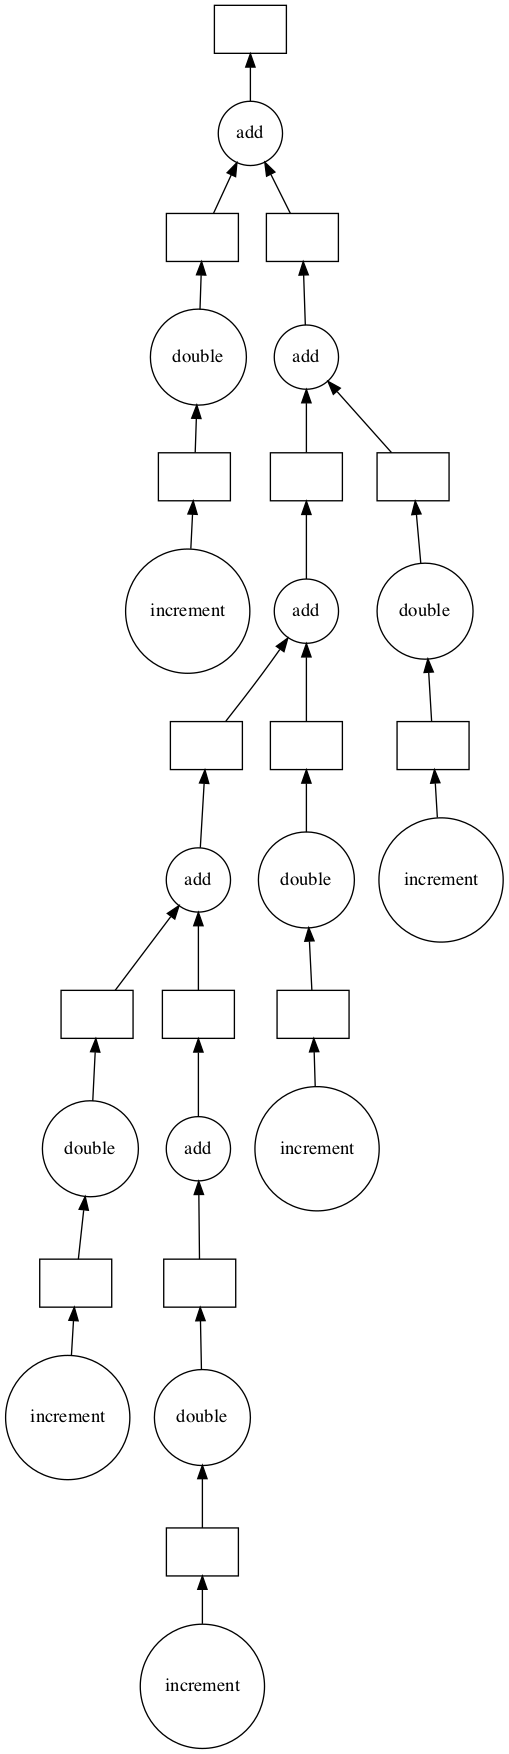

In [8]:
totald.visualize()

- Note that we have not physically calculated **total** yet.
- We need to apply the `compute` method to get the answer.
- <font color="red">It is only here that the data are loaded into memory for calculations</font>.

In [9]:
%%time
dask.compute(totald)

CPU times: user 13.1 ms, sys: 6.18 ms, total: 19.3 ms
Wall time: 7.03 s


(40,)

## <font color="blue"> Schedulers</font>

- After Dask generates the task graphs, it needs to execute them on parallel hardware. 
- It is the role of a task scheduler.
- There are different task schedulers. Each will consume a task graph and compute the same result, but with different performance characteristics.

![Schedulers](https://docs.dask.org/en/latest/_images/collections-schedulers.png)
Image Source: https://docs.dask.org/

To execute the task graphs there are two types of schedulers:
* **Single machine**: Provides basic features on a local process or thread pool. It is simple and cheap to use, although it can only be used on a single machine and does not scale
* **Distributed**: Offers more features, but also requires a bit more effort to set up. It can run locally or distributed across a cluster.

**Single thread**

- The single-threaded synchronous scheduler executes all computations in the local thread with no parallelism at all.

In [ ]:
%time total.compute(scheduler='synchronous')

**Local threads**

Uses `multiprocessing.pool.ThreadPool`

Use all the processors

In [ ]:
%time total.compute(scheduler='threads')

Use some of the processors:

In [ ]:
%time total.compute(scheduler='threads', num_workers=2)

**Local processes**

- The multiprocessing scheduler executes computations with a local `multiprocessing.Pool`.
- Every task and all of its dependencies are shipped to a local process, executed, and then their result is shipped back to the main process. 
- Moving data to remote processes and back can introduce performance penalties, particularly when the data being transferred between processes is large. 
- The multiprocessing scheduler is an excellent choice when workflows are relatively linear, and so does not involve significant inter-task data transfer as well as when inputs and outputs are both small, like filenames and counts.

Use all the processors:

In [ ]:
import multiprocessing
print (multiprocessing.cpu_count())

In [ ]:
%time result = total.compute(scheduler='processes')

Use some of the processors:

In [ ]:
%time result = total.compute(scheduler='processes', num_workers=2)

**Dask distributed scheduler: Run through a Dashboard**

- The Dask distributed scheduler can either be setup on a cluster or run locally on a personal machine. 
- It is a centrally managed, distributed, dynamic task scheduler. The central dask-scheduler process coordinates the actions of several dask-worker processes spread across multiple machines and the concurrent requests of several clients.
- The scheduler is asynchronous and event-driven, simultaneously responding to requests for computation from multiple clients and tracking the progress of multiple workers.
- The event-driven and asynchronous nature makes it flexible to concurrently handle a variety of workloads coming from multiple users at the same time while also handling a fluid worker population with failures and additions. 
- Workers communicate amongst each other for bulk data transfer over TCP.
- To set up `dask.distributed`, we need to create client instance by calling `Client` class from `dask.distributed`. 
- It will internally create a dask scheduler and dask workers. 
- We will get the link of the dashboard where we can analyze tasks running in parallel. 
- We can pass a number of workers (using the `n_workers` argument) and threads to use per worker process (using the `threads_per_worker` argument).
- As soon as you create a client, Dask will automatically start using it.

In [ ]:
from dask.distributed import Client
client = Client(n_workers=2, threads_per_worker=4)
client

In [ ]:
import random

def random_slow_add(x, y):
    time.sleep(random.randrange(8,15))
    return x + y

In [ ]:
results = []

for x in data:
    y = dask.delayed(random_slow_add)(x, 1)
    results.append(y)
    
total = dask.delayed(sum)(results)

In [ ]:
%time result = total.compute()
result

In [ ]:
# Shut down the cluster
client.close()

# <font color="red"> Dask DataFrames</font>

- Pandas is great for tabular datasets that fit in memory. 
- Dask becomes useful when the dataset you want to analyze is larger than your machine's RAM. 
- Dask DataFrames:
     - Coordinate many Pandas DataFrames, partitioned along an index. 
     - Support a large subset of the Pandas API.
- One operation on a Dask DataFrame triggers many Pandas operations on the constituent pandas DataFrames in a way that is mindful of potential parallelism and memory constraints.
- Some of the operations that are really fast if you use Dask Dataframes:
     - Arithmetic operations (multiplying or adding to a Series)
     - Common aggregations (`mean`, `min`, `max`, `sum`, etc.)
     - Calling `apply`
     - Calling `value_counts()`, `drop_duplicates()` or `corr()`
     - Filtering with `loc`, `isin`, and row-wise selection

![fig_df](https://pythondata.com/wp-content/uploads/2016/11/Screen-Shot-2016-11-24-at-6.52.24-PM-168x300.png)

Build a Pandas DataFrame with 100000 rows and two columns with values selected randomly between 1 and 1000.

In [ ]:
num_rows = 100000
df = pd.DataFrame({'X':np.random.randint(1000, size=num_rows),
                   'Y':np.random.randint(1000, size=num_rows)})
df

Write a function that computes the sum of square for each column of the DataFrame.

In [ ]:
def add_squares(df):
    return df.X**2 + df.Y**2

Measure the time it takes to call the function:

In [ ]:
%%timeit
df['add_squares'] = df.apply(add_squares,axis=1)

In [ ]:
df

**Parallelize using Dask `Map_Partition`**

We construct a Dask DataFrame from pandas dataframe using `from_pandas` function and specify the number of partitions (`nparitions`) to break this dataframe into.

```python
   dd = ddf.from_pandas(df, npartitions=N)
```

`ddf` is the name you imported Dask Dataframes with, and `npartitions` is an argument telling the Dataframe how you want to partition it.

Each partition will run on a different thread, and communication between them will become too costly if there are too many.

We will break into 4 partitions (number of available cores):

In [ ]:
ddf = dd.from_pandas(df, npartitions=4)

We will apply `add_squares` method on each of these partitions:

In [ ]:
%%timeit
ddf['z'] = ddf.map_partitions(add_squares, 
                               meta=(None, 'int64')).compute()

In [ ]:
def myfunc(x, y):
    return y * (x**2 + 1)

In [ ]:
%%timeit
df1 = df.apply(lambda row: myfunc(row.X, row.Y), axis=1)

In [ ]:
import multiprocessing
ddf = dd.from_pandas(df, npartitions=4*multiprocessing.cpu_count())
ddf

In [ ]:
%%timeit
ddfz = ddf.map_partitions(lambda data: 
                              data.apply(lambda row: myfunc(row.X, row.Y), axis=1)).compute(scheduler='processes')

**NYC Flights Dataset**

Download the remote data:

In [ ]:
import urllib.request

print("\t Downloading NYC dataset...", end="\n", flush=True)

url = "https://storage.googleapis.com/dask-tutorial-data/nycflights.tar.gz"
filename, header = urllib.request.urlretrieve(url, "nycflights.tar.gz")

print("\t Done!", flush=True)

Extract the `.csv` files from the tar file:

In [ ]:
import tarfile

with tarfile.open(filename, mode="r:gz") as flights:
     flights.extractall("data/")

Read all the files at once:

In [ ]:
df = dd.read_csv(os.path.join("data", "nycflights", "*.csv"), 
                parse_dates={"Date": [0, 1, 2]})
df

- The representation of the dataframe object contains no data. 
- Dask has just done enough to read first few rows of thefirst file, and infer the column names and data types.

We can display the first few rows:

In [ ]:
df.head()

If we display the last few rows, we have a problem:

In [ ]:
df.tail()

- There is an issue with the data types of few columns.
- We can fix it by reading the files again and specify the appropriate data types.

In [ ]:
df = dd.read_csv(os.path.join("data", "nycflights", "*.csv"), 
                parse_dates={"Date": [0, 1, 2]},
                dtype={'TailNum': str,
                       'CRSElapsedTime': float,
                       'Cancelled': bool})

In [ ]:
df.tail()

- We now want to compute the mximum of the `DepDelay` column.
- With `Pandas`, we would loop over each file to find the individual maximums, then find the final maximum over all the individual maximums.
- `dask.dataframe` allows us to write pandas-like code that operates on large than memory datasets in parallel.

In [ ]:
%time df.DepDelay.max().compute()

As with `Delayed` objects, you can view the underlying task graph using the `visualize` method:

In [ ]:
df.DepDelay.max().visualize(rankdir="LR", size="12, 12!")